<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#extra-one-hot-features" data-toc-modified-id="extra-one-hot-features-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>extra one-hot features</a></span></li><li><span><a href="#extra-keywords" data-toc-modified-id="extra-keywords-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>extra keywords</a></span></li></ul></li><li><span><a href="#Dense" data-toc-modified-id="Dense-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dense</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Text-Classification/code")
!pip install pyLDAvis
!pip install gensim
!pip install pandas==1.3.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from classification_utils import *
from clustering_utils import *
from eda_utils import *
from nn_utils_keras import *
from feature_engineering_utils import *
from data_utils import *

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
train, test = load_data(only_stem_voc=True)
# train, test = load_data(sample50=True)
#  train, upsampling_info = upsampling_train(train)

train_text, train_label = train_augmentation(train, select_comb=None)
test_text, test_label = test['text'], test['label']

# test_text = test_text.apply(lambda x: extract_stem_voc(x))
# train_text = train_text.apply(lambda x: extract_stem_voc(x))
# train_text.to_csv("stem_voc_train.csv")
# test_text.to_csv("stem_voc_test.csv")

# train_text, test_text = load_stem_voc()


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


In [4]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)
y_train = train_label
y_test = test_label

print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)
print(labels)

(11083,)
(7761,)
(11083,)
(7761,)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


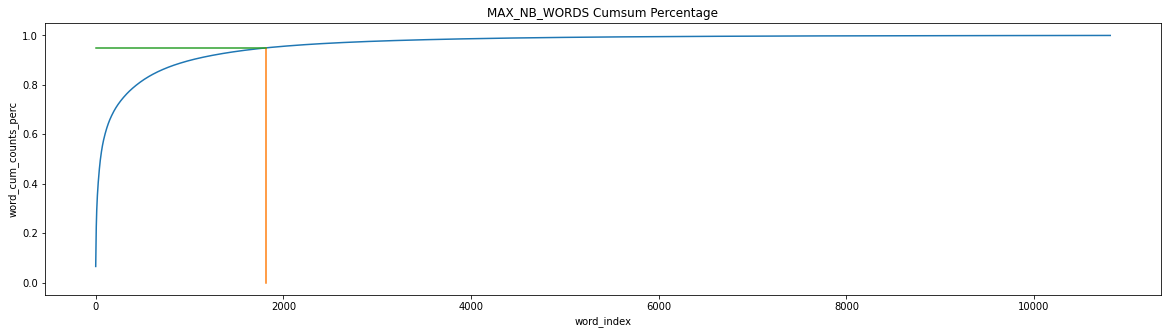

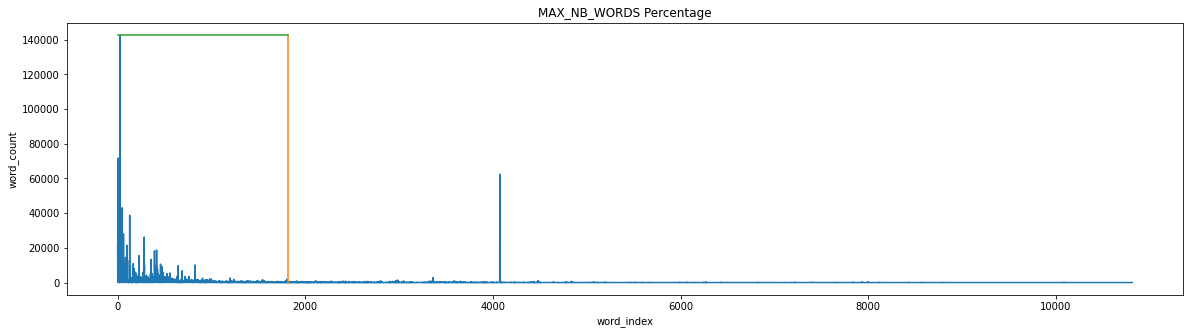

Cut index with 95.0 % of corpus:  1820 

    index  word   count
0      27   the  142476
1       6    to   71797
2      15    of   68191
3    4073    ax   62511
4      21   and   56944
5      28    in   47583
6      49    is   43091
7     129  that   38781
8      35    it   35601
9      63   for   28036
10    284   you   26258
11      0  from   22170
12    100    be   21418
13     40    on   19654
14    416  have   18766
15     25   are   18423
16    393   not   18290
17     44  with   17075
18    226    as   15577
19     85    or   14561


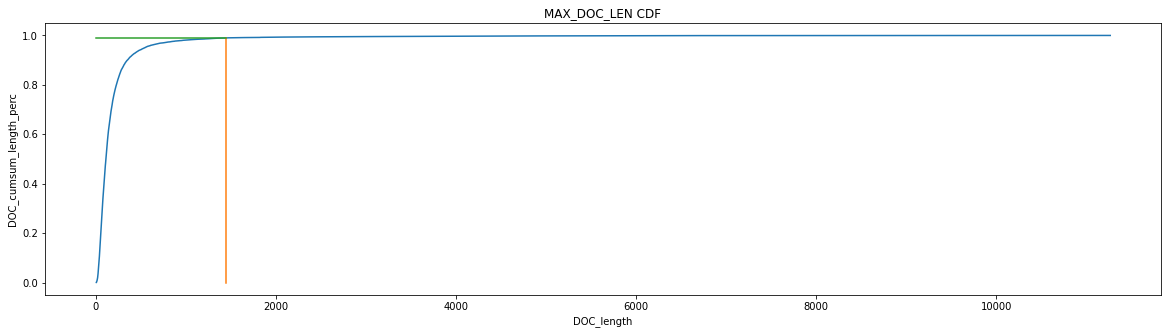

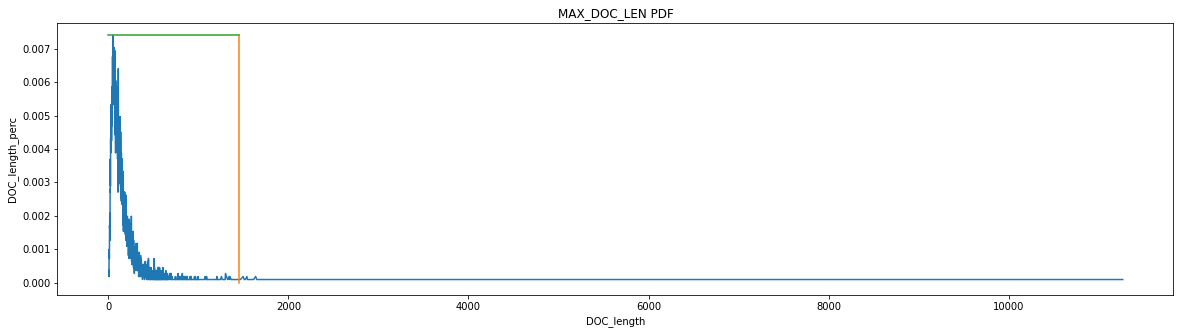

Cut index with 99.0 % of corpus:  1452


In [5]:
####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.99
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

## extra one-hot features

In [7]:
# one_hot_X_train, one_hot_X_test, one_hot_word_to_idx, one_hot_count_vect = count_vectorizer(
#     train['Subject']+" " + train['Organization'], test['Subject']+" " + test['Organization'], stop_words=True, binary=False, min_df=3, max_df=0.001)

## extra keywords

In [8]:
# label_docs = train.groupby('label')['text'].apply(lambda x: " ".join(x)) # 要去除标点符号
# dtm, _, label_word_to_idx, _ = count_vectorizer(label_docs, [''], stop_words=True, min_df=1, binary=True)
# label_idx_to_word = dict([val, key] for key, val in label_word_to_idx.items())
# keywords_threshold = 1
# keywords_idx = np.where(dtm.sum(axis=0)<=keywords_threshold)[0]
# print(" keywords_idx shape: ")
# voc = [label_idx_to_word[idx] for idx in keywords_idx]

# keywords_X_train, keywords_X_test, keywords_word_to_idx, keywords_count_vect = count_vectorizer(
#     train['text'], test['text'], voc=voc, stop_words=True, min_df=1, binary=True)

# Dense

In [9]:
X_train, X_test, word_to_idx, tfidf_vect = tfidf_vectorizer(train_text, test_text, stop_words=True, binary=True, min_df=5, ngram_range=(2,3))
X_train, transform_mapper = dimension_reduction(X_train, out_dim=500) # not allow negative 
X_test = transform_mapper.transform(X_test)

num of words: 43562
Dimension reduction with truncate SVD:
   input columns with  43562
   output columns with  500


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [10]:
# stop

# del X_train
# del X_test


In [11]:
_X_train = np.hstack([X_train])
_X_test = np.hstack([X_test])
# _X_train = np.hstack([X_train, keywords_X_train])
# _X_test = np.hstack([X_test, keywords_X_test])

# _X_train = np.hstack([X_train, one_hot_X_train, keywords_X_train])
# _X_test = np.hstack([X_test, one_hot_X_test, keywords_X_test])

In [12]:
opt = optimizers.Adam(learning_rate=0.005)

model = Sequential()
model.add(Input(shape=_X_train.shape[1],))  # input cannot connect with dropout directly
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer=opt,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])


# model.compile(optimizer=opt,
#                 loss=keras.losses.CategoricalHinge(),
#               metrics=[keras.metrics.CategoricalAccuracy()])

In [15]:
BATCH_SIZE = 64 # 16 # 先在小的batch上train, 容易找到全局最优部分, 然后再到 大 batch 上train, 快速收敛到局部最优
NUM_EPOCHES = 100  # 20步以上
patience = 80

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_6'
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(_X_train, y_train, validation_data=(_X_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)

history = model.fit(_X_train, y_train, validation_data=(_X_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=None, verbose=1)
# history = model.fit(_X_train, to_categorical(y_train), validation_data=(_X_test,to_categorical(y_test)), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=None, verbose=1)
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)

Epoch 1/100
174/174 [==============================] - 1s 4ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8258 - val_loss: 1.6489 - val_sparse_categorical_accuracy: 0.5656
Epoch 2/100
174/174 [==============================] - 1s 3ms/step - loss: 0.5429 - sparse_categorical_accuracy: 0.8150 - val_loss: 1.6009 - val_sparse_categorical_accuracy: 0.5801
Epoch 3/100
174/174 [==============================] - 1s 3ms/step - loss: 0.5192 - sparse_categorical_accuracy: 0.8203 - val_loss: 1.6529 - val_sparse_categorical_accuracy: 0.5695
Epoch 4/100
174/174 [==============================] - 1s 3ms/step - loss: 0.5018 - sparse_categorical_accuracy: 0.8301 - val_loss: 1.6334 - val_sparse_categorical_accuracy: 0.5802
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.4816 - sparse_categorical_accuracy: 0.8351 - val_loss: 1.6939 - val_sparse_categorical_accuracy: 0.5655
Epoch 6/100
174/174 [==============================] - 1s 3ms/step - loss: 0.4878 - sparse_cate

loss val_loss


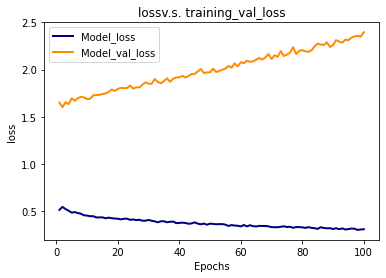

sparse_categorical_accuracy val_sparse_categorical_accuracy


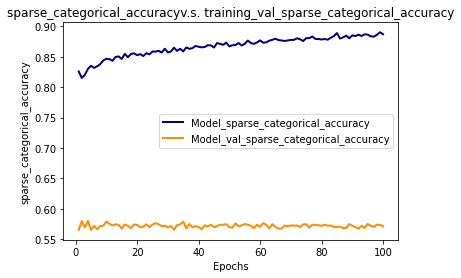

classification_report:
f1:  {'micro avg': 0.5715758278572349, 'macro avg': 0.5754584585826703} 

                          precision  recall  f1-score  support
alt.atheism                   0.679   0.596     0.634    319.0
comp.graphics                 0.398   0.458     0.426    389.0
comp.os.ms-windows.misc       0.588   0.442     0.504    394.0
comp.sys.ibm.pc.hardware      0.432   0.515     0.470    392.0
comp.sys.mac.hardware         0.478   0.470     0.474    385.0
comp.windows.x                0.431   0.473     0.451    395.0
misc.forsale                  0.700   0.813     0.752    390.0
rec.autos                     0.607   0.516     0.558    395.0
rec.motorcycles               0.627   0.696     0.660    398.0
rec.sport.baseball            0.408   0.713     0.519    397.0
rec.sport.hockey              0.911   0.297     0.448    827.0
sci.crypt                     0.871   0.768     0.816    396.0
sci.electronics               0.475   0.430     0.451    393.0
sci.med              

In [16]:
#### classification Report
history_plot(history)
y_pred = model.predict(_X_test)
classification_report = evaluation_report(y_test, np.argmax(y_pred, axis=1), labels=labels)

scores = model.evaluate(_X_test, y_test, verbose=2)
roc_auc(y_test, y_pred)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")